Using RGB color space


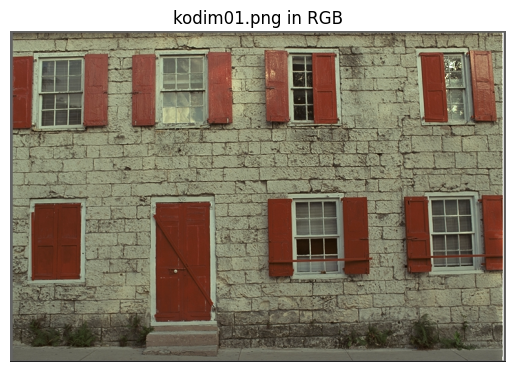

Using YCoCg color space
Preset: Preset: fnlic     
-------

Warm-up
-------
+--------------+--------------+--------------------+---------+----------------+-------------+-------------+-------------+------------------+--------------+
|  Candidates  |  Learn rate  |  Module optimized  | Max itr | Patience [itr] | Valid [itr] | Quantize NN | Schedule lr |  Softround Temp  |    Noise     |
+--------------+--------------+--------------------+---------+----------------+-------------+-------------+-------------+------------------+--------------+
|      5       |   1.00e-02   |        all         |   400   |     100000     |     100     |      0      |      0      | 3.0e-01, 3.0e-01 |  1.00, 0.50  |
|      2       |   1.00e-02   |        all         |  1000   |     100000     |     100     |      0      |      0      | 3.0e-01, 3.0e-01 |  0.50, 0.25  |
+--------------+--------------+--------------------+---------+----------------+-------------+-------------+-------------+------------------+----

In [1]:
import os
import sys

if os.path.basename(os.getcwd()) == "testing":
    os.chdir(os.path.dirname(os.getcwd()))
    sys.path.append(os.getcwd())

import torch
from lossless.component.coolchic import CoolChicEncoder
from lossless.configs.config import args, str_args
from lossless.training.loss import loss_function
from lossless.training.manager import ImageEncoderManager
from lossless.training.train import train
from lossless.training.train import _train_single_phase
from lossless.util.command_line_args_loading import load_args
from lossless.util.image_loading import load_image_as_tensor
from lossless.util.logger import TrainingLogger
from lossless.util.parsecli import get_coolchic_param_from_args
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)
torch.set_float32_matmul_precision("high")
# torch._logging.set_logs(graph_code=True)

# ==========================================================================================
# LOAD COMMAND LINE ARGS AND IMAGE
# ==========================================================================================
command_line_args = load_args(
    notebook_overrides={
        "image_index": 0,
        "encoder_gain": 64,
        "color_space": "YCoCg",
        "use_image_arm": True,
    }
)
im_path = args["input"][command_line_args.image_index]
im_tensor, colorspace_bitdepths = load_image_as_tensor(
    im_path, device="cuda:0", color_space="RGB"
)
plt.imshow(im_tensor[0].cpu().permute(1, 2, 0).numpy())
plt.axis("off")
plt.title(f"{im_path.split('/')[-1]} in RGB")
plt.show()
im_tensor, colorspace_bitdepths = load_image_as_tensor(
    im_path, device="cuda:0", color_space=command_line_args.color_space
)

# ==========================================================================================
# LOAD PRESETS, COOLCHIC PARAMETERS
# ==========================================================================================
image_encoder_manager = ImageEncoderManager(
    preset_name=args["preset"], colorspace_bitdepths=colorspace_bitdepths
)

encoder_param = get_coolchic_param_from_args(
    args,
    "lossless",
    image_size=(im_tensor.shape[2], im_tensor.shape[3]),
    use_image_arm=command_line_args.use_image_arm,
    encoder_gain=command_line_args.encoder_gain,
)
coolchic = CoolChicEncoder(param=encoder_param)
coolchic.to_device("cuda:0")
# ==========================================================================================
# SETUP LOGGER
# ==========================================================================================
dataset_name = im_path.split("/")[-2]
logger = TrainingLogger(
    log_folder_path=args["LOG_PATH"],
    image_name=f"{dataset_name}_" + im_path.split("/")[-1].split(".")[0],
    debug_mode=image_encoder_manager.n_itr < 1000,
    experiment_name=command_line_args.experiment_name,
)
with open(args["network_yaml_path"], "r") as f:
    network_yaml = f.read()
logger.log_result(f"Preset: {image_encoder_manager.preset.pretty_string()}")
# logger.log_result(f"Network YAML configuration:\n{network_yaml}")
logger.log_result(f"{str_args(args)}")
logger.log_result(f"Processing image {im_path}")
logger.log_result(
    f"Using color space {command_line_args.color_space} with bitdepths {image_encoder_manager.colorspace_bitdepths.bitdepths}"
)
logger.log_result(f"Using image ARM: {command_line_args.use_image_arm}")
logger.log_result(f"Using encoder gain: {command_line_args.encoder_gain}")
logger.log_result(f"Using multi-region image ARM: {args['multi_region_image_arm']}")
logger.log_result(f"Using color regression: {args['use_color_regression']}")
logger.log_result(f"Total training iterations: {image_encoder_manager.n_itr}")
with torch.no_grad():
    logger.log_result(f"Total MAC per pixel: {coolchic.get_total_mac_per_pixel()}")
    logger.log_result(coolchic.str_complexity())

In [2]:
coolchic = train(
    model=coolchic,
    target_image=im_tensor,
    image_encoder_manager=image_encoder_manager,
    logger=logger,
)
logger.log_result(
    f"Training completed in {image_encoder_manager.total_training_time_sec:.2f} seconds"
)

------------------------------  Warm-up phase:  0 ------------------------------

Candidate n° 0 , ID = 0 :
-------------------------

--------------------------------------------------------------------
| Warmup-cand-in 00-00           cpu:  1.326 GB --- gpu:  0.014 GB |
--------------------------------------------------------------------
Model compiled implementation is at: <function Module._call_impl at 0x76f37c3dc9d0>
new rate is: 7.167785882949829, old rate is: 10.018010139465332
delta loss: 2.850224494934082, flag new record: True
Found new best model!
Iteration: 100, Loss: 7.16778564453125, Rate NN: 0.0, Rate Latent: 1.7207753658294678, Rate Img: 5.447010517120361
new rate is: 6.338411808013916, old rate is: 7.167785882949829
delta loss: 0.829373836517334, flag new record: True
Found new best model!
Iteration: 200, Loss: 6.338411808013916, Rate NN: 0.0, Rate Latent: 1.1652803421020508, Rate Img: 5.173131465911865
new rate is: 6.0935362577438354, old rate is: 6.338411808013916
de

In [3]:
rate_per_module, total_network_rate = coolchic.get_network_rate()
total_network_rate = float(total_network_rate) / im_tensor.numel()

with torch.no_grad():
    # Forward pass with no quantization noise
    predicted_prior = coolchic.forward(
        image=im_tensor,
        quantizer_noise_type="none",
        quantizer_type="hardround",
        AC_MAX_VAL=-1,
        flag_additional_outputs=False,
    )
    predicted_priors_rates = loss_function(
        predicted_prior,
        im_tensor,
        rate_mlp_bpd=total_network_rate,
        colorspace_bitdepths=colorspace_bitdepths,
    )

logger.save_model(coolchic, predicted_priors_rates.loss.item())
logger.log_result(
    f"Final frame_encoder_manager state: {image_encoder_manager},\n"
    f"Rate per module: {rate_per_module},\n"
    f"Final results after quantization: {predicted_priors_rates}"
)

Model saved at /home/jakub/ETH/thesis/Cool-Chic/coolchic/../logs/full_runs/2026_01_23_default_name/trained_models/2026_01_23__15_04_01__trained_coolchic_kodak_kodim01_img_rate_3.2547428607940674.pth with rate 3.2547428607940674 bpd.
Final frame_encoder_manager state: ImageEncoderManager(colorspace_bitdepths=<lossless.util.color_transform.YCoCgBitdepths object at 0x76126526fb50>, preset_name='fnlic', start_lr=0.01, n_itr=142200, n_loops=1, preset=PresetFNLIC(preset_name='fnlic', warmup=Warmup(phases=[WarmupPhase(candidates=5, training_phase=TrainerPhase(lr=0.01, max_itr=400, freq_valid=100, patience=100000, quantize_model=False, schedule_lr=False, softround_temperature=(0.3, 0.3), noise_parameter=(1.0, 0.5), quantizer_noise_type='kumaraswamy', quantizer_type='softround', optimized_module=['all'])), WarmupPhase(candidates=2, training_phase=TrainerPhase(lr=0.01, max_itr=1000, freq_valid=100, patience=100000, quantize_model=False, schedule_lr=False, softround_temperature=(0.3, 0.3), noise_

In [2]:
coolchic.load_from_disk("test-workdir/2026_01_22__15_06_30__trained_coolchic_kodak_kodim01_img_rate_3.290357828140259")

In [7]:
from lossless.io.decode_with_predictor import decode_with_predictor
from lossless.io.encode_with_predictor import encode_with_predictor
from lossless.io.encoding_interfaces.image_encoding_interface import \
    ImageEncodeDecodeInterface
import time

encode_decode_start_time = time.time()
coolchic.to_device("cpu")
im_tensor = im_tensor.to("cpu")
with torch.no_grad():
    raw_synth_out, decoder_side_latent = coolchic.get_latents_raw_synth_out(AC_MAX_VAL=-1)

# first do image
enc_dec_im_interface = ImageEncodeDecodeInterface(
    data=(torch.clone(im_tensor), torch.clone(raw_synth_out)),
    model=coolchic,
    ct_range=colorspace_bitdepths,
)
bitstream_im, im_symbols_pre_encoding, _, _ = encode_with_predictor(
    enc_dec_interface=enc_dec_im_interface,
    logger=logger,
    distribution="logistic",
    output_path=None,
)
logger.log_result(f"Finished encoding in {time.time() - encode_decode_start_time:.2f} seconds.")
im_symbols_post_encoding, prob_distributions = decode_with_predictor(
    enc_dec_interface=enc_dec_im_interface,
    bitstream=bitstream_im,
    bitstream_path=None,
    distribution="logistic",
)
logger.log_result("Image encode-decode finished.")
logger.log_result(f"Total encode-decode time: {time.time() - encode_decode_start_time:.2f} seconds.")
is_im_encode_decode_equal = torch.equal(
    torch.tensor(im_symbols_pre_encoding), torch.tensor(im_symbols_post_encoding)
)
logger.log_result(f"Image encode-decode equality check: {is_im_encode_decode_equal}")
logger.log_result(f"Rate Img bistream: {bitstream_im.nbytes * 8 / im_tensor.numel()}")

Theoretical bits per sub pixel: 3.095705017015847
Finished encoding in 395.82 seconds.
Image encode-decode finished.
Total encode-decode time: 795.71 seconds.
Image encode-decode equality check: True
Rate Img bistream: 3.0957573784722223


In [4]:
coolchic.save_to_disk(
    "test-workdir/2026_01_22__15_06_30__trained_coolchic_kodak_kodim01_img_rate_3.290357828140259"
)

In [21]:
print(coolchic.image_arm.params.multi_region_image_arm)
print(coolchic.image_arm.params.multi_region_image_arm_specification)

False
MultiImageArmDescriptor(expert_indices=[tensor([     0,      1,      2,  ..., 393213, 393214, 393215])], num_arms=tensor(1), image_height=tensor(512), image_width=tensor(768), routing_grid=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32))


In [ ]:
from lossless.component.core.arm_image import ImageArm
from lossless.component.types import IMARM_SPLIT_DIRECTION

def split_image_arm_expert(self: ImageArm, expert_idx: int, split_direction: IMARM_SPLIT_DIRECTION) -> None:
    self.params.multi_region_image_arm = True
    new_expert_index = self.params.multi_region_image_arm_specification.num_arms
    

ImageArm.split_image_arm_expert = split_image_arm_expert